In [ ]:

import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz



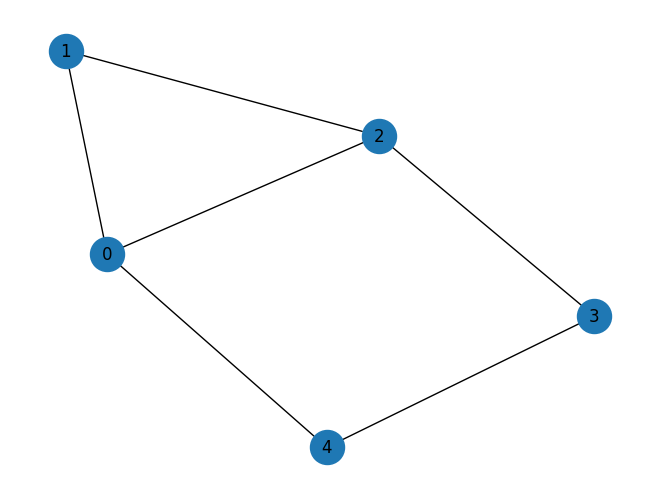

In [161]:
n = 5
 
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 4, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [163]:
# Sum the weights, and divide by 2
 
offset = -sum(edge[2] for edge in edge_list) / 2
print(f"""Offset: {offset}""")

Offset: -3.0


In [75]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.
 
    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("ZZ", [edge[0], edge[1]], weight))
    return pauli_list
 
 
max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, n)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


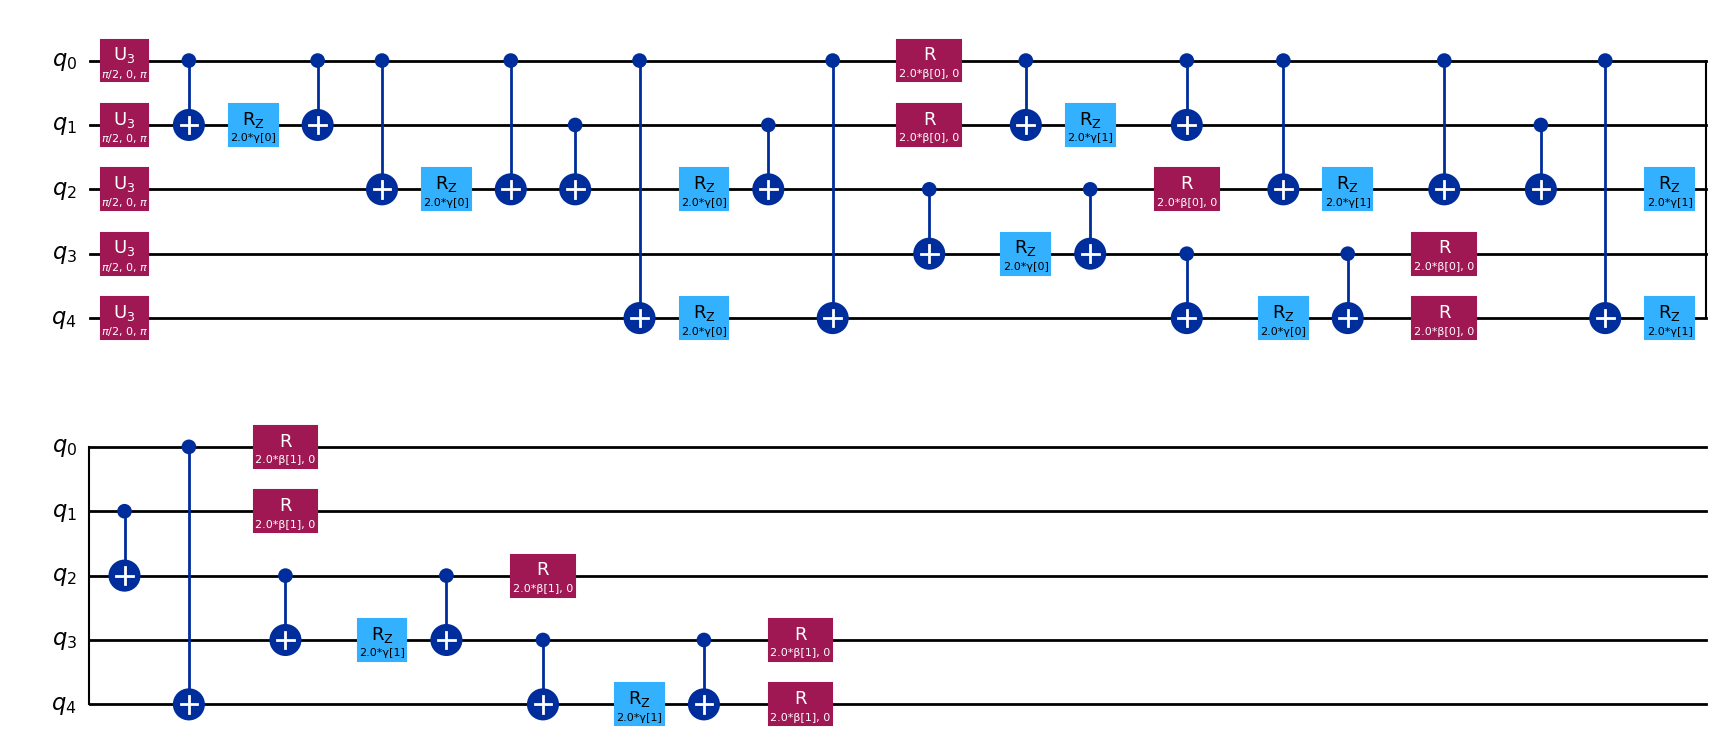

In [76]:
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
# circuit.measure_all()
 
circuit.decompose(reps = 3).draw("mpl")

In [77]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

In [78]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta, initial_beta, initial_gamma, initial_gamma]

In [79]:
objective_func_vals = []


def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator
 
    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
 
    Returns:
        float: Energy estimate
    """
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    objective_func_vals.append(cost)
    #    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [80]:
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.primitives import StatevectorSampler as Sampler
 
estimator = Estimator()
sampler = Sampler()

In [81]:
result = minimize(
    cost_func, init_params, args=(circuit, cost_hamiltonian, estimator), method="COBYLA"
)

result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.2468593213581283
       x: [ 2.088e+00  1.880e+00  2.849e+00  2.627e+00]
    nfev: 83
   maxcv: 0.0

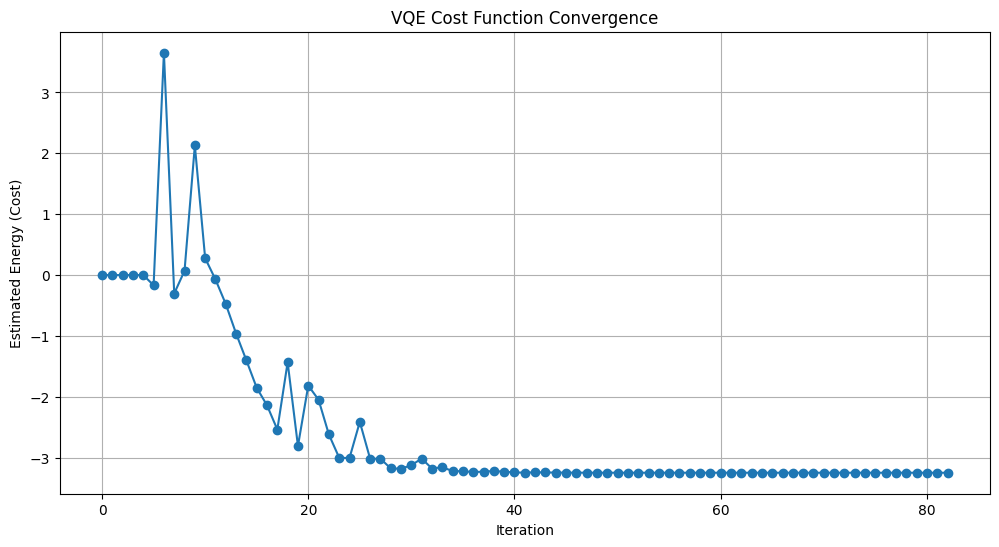

In [82]:
# Plot convergence of cost function
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals, marker='o', linestyle='-')
plt.title("VQE Cost Function Convergence")
plt.xlabel("Iteration")
plt.ylabel("Estimated Energy (Cost)")
plt.grid(True)
plt.show()

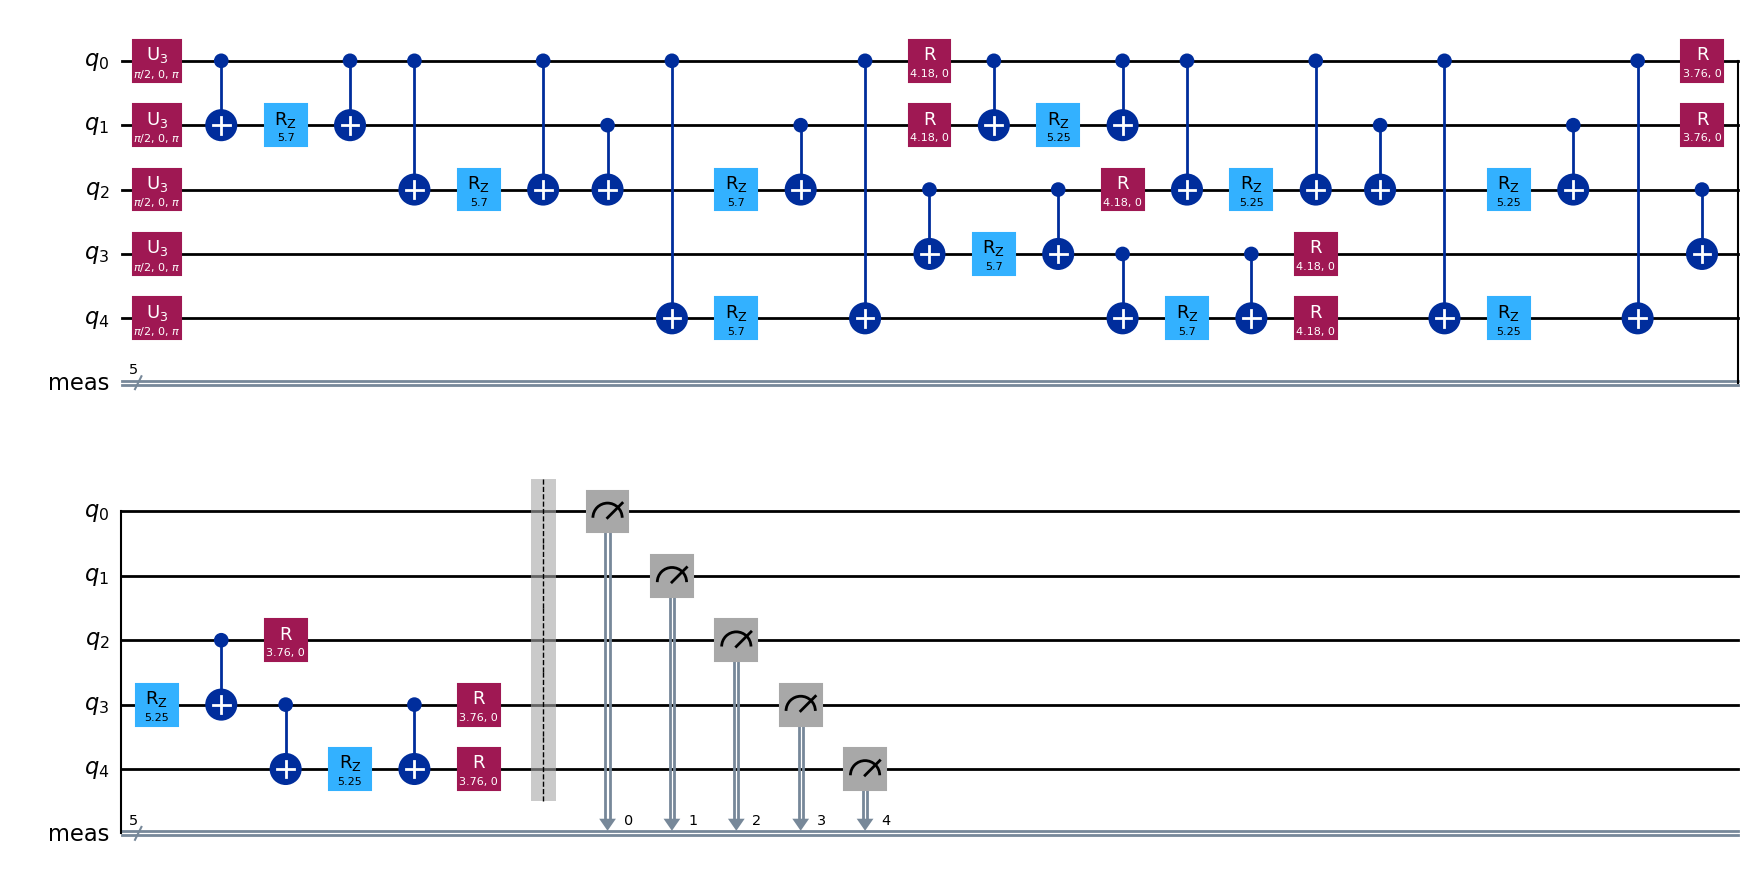

In [83]:
from qiskit.result import QuasiDistribution
from qiskit.primitives import StatevectorSampler
 
sampler = StatevectorSampler()
 
# Assign solution parameters to ansatz
qc = circuit.assign_parameters(result.x)
 
# Add measurements to our circuit
qc.measure_all()
 
# Sample ansatz at optimal parameters
# samp_dist = sampler.run(qc).result().quasi_dists[0]
 
shots = 1024
job = sampler.run([qc], shots=shots)

qc.decompose(reps = 3).draw("mpl")

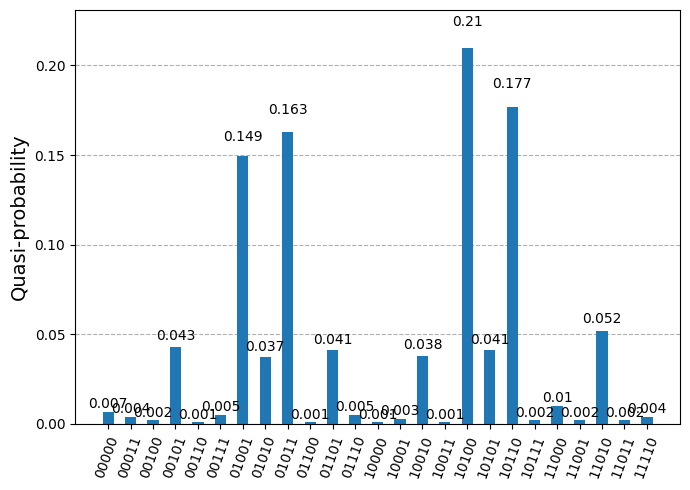

In [84]:
data_pub = job.result()[0].data
bitstrings = data_pub.meas.get_bitstrings()
counts = data_pub.meas.get_counts()
quasi_dist = QuasiDistribution(
    {outcome: freq / shots for outcome, freq in counts.items()}
)
probabilities = quasi_dist
 
# Close the session since we are now done with it
# session.close()

from qiskit.visualization import plot_distribution
 
plot_distribution(counts)

Max-cut = -5


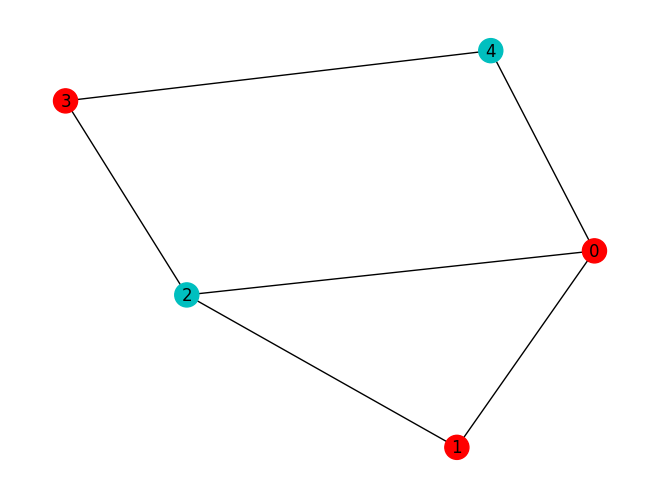

In [171]:
binary_string = max(counts.items(), key=lambda kv: kv[1])[0]
x = np.asarray([int(y) for y in reversed(list(binary_string))])
 
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(
    graph, node_color=colors, with_labels=True
)

print(f'Max-cut = {result.fun/2 + offset : .0f}')

In [175]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(
        list(graph.nodes())
    ), "The length of x must coincide with the number of nodes in the graph."
    return sum(
        x[u] * (1 - x[v]) + x[v] * (1 - x[u])
        for u, v in list(graph.edge_list())
    )
 
 
cut_value = evaluate_sample(x, graph)
print("The value of the cut is:", cut_value)

The value of the cut is: 5
